# Solar Energy Power Generation Dataset - Plant_2

## this notebook uses weather data to forecast solar output - https://www.kaggle.com/datasets/pythonafroz/solar-power for 2 stations Plant_1 and Plant_2

# Since solar panels convert sunlight into DC power that is what we will look at, an inverter is then used to convert this into AC power - so obviously they correlate strongly with each other but we only need to view the DC case.

# Very high accuracy is achieved due to this strong correlation.

In [45]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pandas_profiling
import seaborn as sns
import datetime as dt
import math

import xgboost as xgb# for XGBoost algorithm
from sklearn import linear_model 
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# Set the default plot size
plt.rcParams['figure.figsize'] = [15, 8]
# set a grid for each plot too
sns.set_style("whitegrid")

## Load the data for the first plants weather

In [3]:
df_weather2 = pd.read_csv('../input/solar-power/Plant_2_Weather_Sensor_Data.csv')
df_weather2

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0
...,...,...,...,...,...,...
3254,2020-06-17 22:45:00,4136001,iq8k7ZNt4Mwm3w0,23.511703,22.856201,0.0
3255,2020-06-17 23:00:00,4136001,iq8k7ZNt4Mwm3w0,23.482282,22.744190,0.0
3256,2020-06-17 23:15:00,4136001,iq8k7ZNt4Mwm3w0,23.354743,22.492245,0.0
3257,2020-06-17 23:30:00,4136001,iq8k7ZNt4Mwm3w0,23.291048,22.373909,0.0


# check for missing values - there are none

In [4]:
df_weather2.isna().sum()

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

In [5]:
df_weather2.dtypes

DATE_TIME               object
PLANT_ID                 int64
SOURCE_KEY              object
AMBIENT_TEMPERATURE    float64
MODULE_TEMPERATURE     float64
IRRADIATION            float64
dtype: object

# Convert DATE_TIME column to datetime datatype and make it the index

In [6]:
df_weather2['DATE_TIME'] = pd.to_datetime(df_weather2['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
df_weather2.set_index('DATE_TIME',inplace=True)
df_weather2

,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,
2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0
...,...,...,...,...,...
2020-06-17 22:45:00,4136001,iq8k7ZNt4Mwm3w0,23.511703,22.856201,0.0
2020-06-17 23:00:00,4136001,iq8k7ZNt4Mwm3w0,23.482282,22.744190,0.0
2020-06-17 23:15:00,4136001,iq8k7ZNt4Mwm3w0,23.354743,22.492245,0.0


## How many different values are there for the SOURCE_KEY - 1

In [7]:
df_weather2.SOURCE_KEY.unique()

array(['iq8k7ZNt4Mwm3w0'], dtype=object)

# With the date_time field now set as the index it is possible to do some quick simple graphs to investigate the data. 
## Some potential problems with the data can be seen so some further investigation may be warranted later.
# But the diurnal pattern of solar irradiation can easily be seen with some variations 

<AxesSubplot: xlabel='DATE_TIME', ylabel='IRRADIATION'>

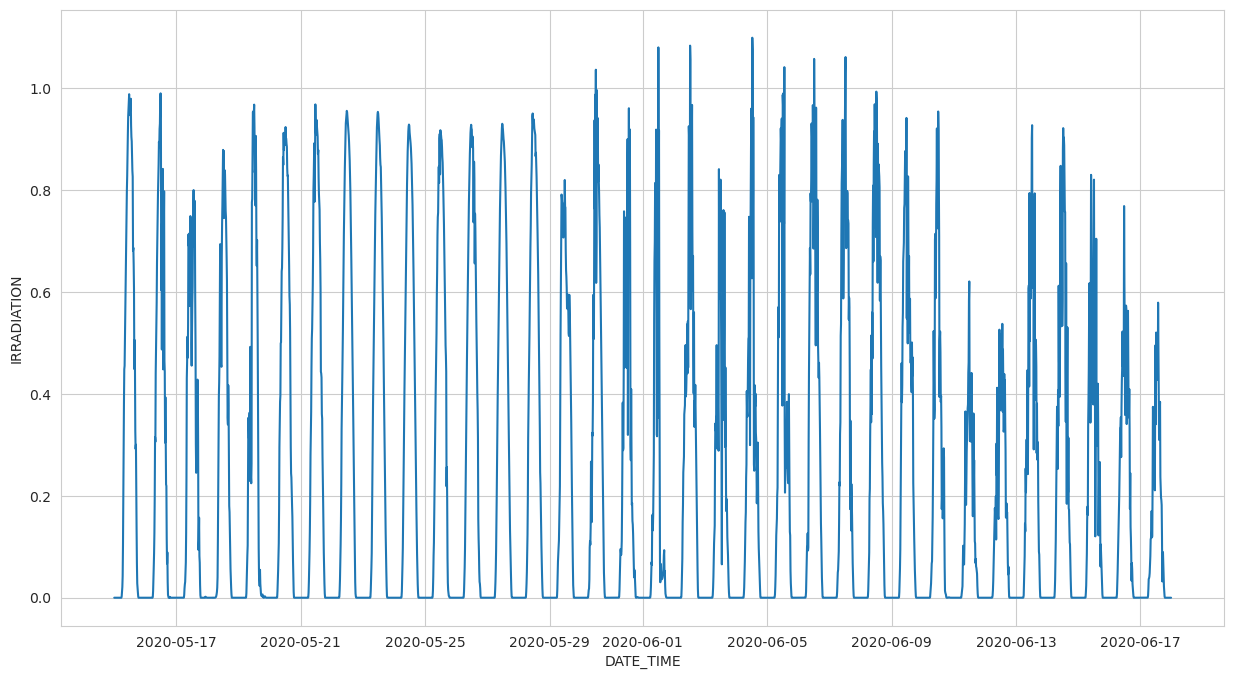

In [8]:

sns.lineplot(data='df_weather2', x=df_weather2.index, y=df_weather2['IRRADIATION'])

# Now to solar generation for plant 1
## interesting point to note - it has the same number of rows as the weather data so it will be easy to join them

In [10]:
df_solar2  = pd.read_csv('../input/solar-power/Plant_2_Generation_Data.csv')
df_solar2

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06
1,2020-05-15 00:00:00,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09
2,2020-05-15 00:00:00,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09
3,2020-05-15 00:00:00,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06
4,2020-05-15 00:00:00,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07
...,...,...,...,...,...,...,...
67693,2020-06-17 23:45:00,4136001,q49J1IKaHRwDQnt,0.0,0.0,4157.000000,5.207580e+05
67694,2020-06-17 23:45:00,4136001,rrq4fwE8jgrTyWY,0.0,0.0,3931.000000,1.211314e+08
67695,2020-06-17 23:45:00,4136001,vOuJvMaM2sgwLmb,0.0,0.0,4322.000000,2.427691e+06
67696,2020-06-17 23:45:00,4136001,xMbIugepa2P7lBB,0.0,0.0,4218.000000,1.068964e+08


# Following the same process as above - set the DATE_TIME column to datetime datatype and make it the index.

In [11]:
df_solar2['DATE_TIME'] = pd.to_datetime(df_solar2['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
df_solar2.set_index('DATE_TIME',inplace=True)
df_solar2

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,,
2020-05-15 00:00:00,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06
2020-05-15 00:00:00,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09
2020-05-15 00:00:00,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09
2020-05-15 00:00:00,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06
2020-05-15 00:00:00,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07
...,...,...,...,...,...,...
2020-06-17 23:45:00,4136001,q49J1IKaHRwDQnt,0.0,0.0,4157.000000,5.207580e+05
2020-06-17 23:45:00,4136001,rrq4fwE8jgrTyWY,0.0,0.0,3931.000000,1.211314e+08
2020-06-17 23:45:00,4136001,vOuJvMaM2sgwLmb,0.0,0.0,4322.000000,2.427691e+06


# Any nullls - no

In [12]:
df_solar2.isna().sum()

PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

# How many SOURCE_KEY - 22 

In [14]:
df_solar2.SOURCE_KEY.nunique()

22

# Again with the date as the index a graph of each of the sources can be done - the generation is usually very similar for each sensor but on occasion there is some variation which might warrant further investigation

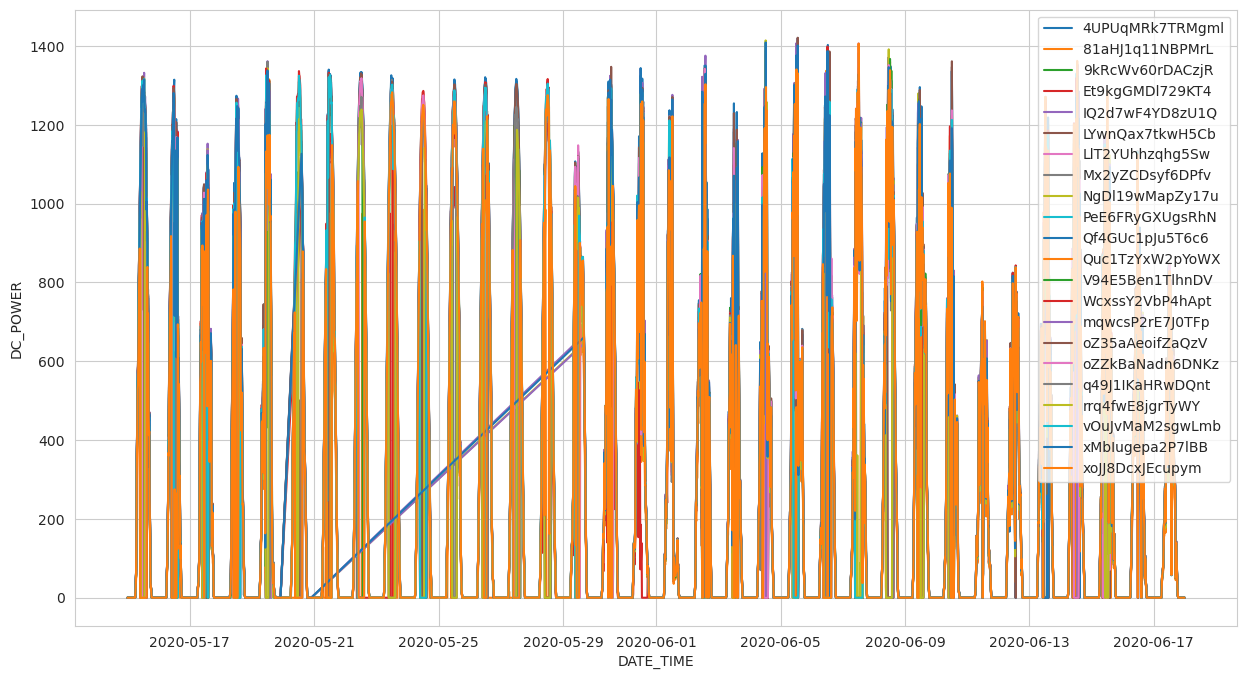

In [15]:
# Make a graph for each SOURCE_KEY

source_key = df_solar2.SOURCE_KEY.unique()    #['1BY6WEcLGh8j5v7','wCURE6d3bPkepu2','7JYdWkrLSPkdwr4']	#
for sk in source_key:
    sns.lineplot(data=df_solar2[df_solar2['SOURCE_KEY']==sk], x=(df_solar2[df_solar2['SOURCE_KEY']==sk]).index, y=df_solar2['DC_POWER'][df_solar2['SOURCE_KEY']==sk], label=sk)

# Putting it all together and joining the df's on index 

In [17]:
df_joined2 = pd.merge(df_solar2,df_weather2, left_on='DATE_TIME', right_on = 'DATE_TIME', how='inner', suffixes=('_solar','_weather' ))
df_joined2

,PLANT_ID_solar,SOURCE_KEY_solar,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_weather,SOURCE_KEY_weather,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,,,,,,,
2020-05-15 00:00:00,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
2020-05-15 00:00:00,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
2020-05-15 00:00:00,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
2020-05-15 00:00:00,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
2020-05-15 00:00:00,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-17 23:45:00,4136001,q49J1IKaHRwDQnt,0.0,0.0,4157.000000,5.207580e+05,4136001,iq8k7ZNt4Mwm3w0,23.202871,22.535908,0.0
2020-06-17 23:45:00,4136001,rrq4fwE8jgrTyWY,0.0,0.0,3931.000000,1.211314e+08,4136001,iq8k7ZNt4Mwm3w0,23.202871,22.535908,0.0
2020-06-17 23:45:00,4136001,vOuJvMaM2sgwLmb,0.0,0.0,4322.000000,2.427691e+06,4136001,iq8k7ZNt4Mwm3w0,23.202871,22.535908,0.0


# Let's drop the SOURCE_KEY and one of the PLANT_ID's


In [18]:
df_joined2.drop(['SOURCE_KEY_solar','SOURCE_KEY_weather','PLANT_ID_weather'], axis=1, inplace=True)
df_joined2

,PLANT_ID_solar,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,,,,
2020-05-15 00:00:00,4136001,0.0,0.0,9425.000000,2.429011e+06,27.004764,25.060789,0.0
2020-05-15 00:00:00,4136001,0.0,0.0,0.000000,1.215279e+09,27.004764,25.060789,0.0
2020-05-15 00:00:00,4136001,0.0,0.0,3075.333333,2.247720e+09,27.004764,25.060789,0.0
2020-05-15 00:00:00,4136001,0.0,0.0,269.933333,1.704250e+06,27.004764,25.060789,0.0
2020-05-15 00:00:00,4136001,0.0,0.0,3177.000000,1.994153e+07,27.004764,25.060789,0.0
...,...,...,...,...,...,...,...,...
2020-06-17 23:45:00,4136001,0.0,0.0,4157.000000,5.207580e+05,23.202871,22.535908,0.0
2020-06-17 23:45:00,4136001,0.0,0.0,3931.000000,1.211314e+08,23.202871,22.535908,0.0
2020-06-17 23:45:00,4136001,0.0,0.0,4322.000000,2.427691e+06,23.202871,22.535908,0.0


# Taking the mean output from all of the SOURCE_KEY's

In [20]:
df_group2 = df_joined2[['DC_POWER','IRRADIATION','AMBIENT_TEMPERATURE','DAILY_YIELD', ]].groupby('DATE_TIME').mean()

# Also add a column to get to the same scale - multiply the IRRADIATION by 1000 - so we can put both on the same graph.
## This graph shows the correlation between AC_POWER and IRRADIATION well.

In [28]:
df_group2['IRRADIATIONx1000'] = df_group2['IRRADIATION']*1000

Text(0.5, 1.0, 'Irradiation (x1000 for scale) versus the DC_POWER')

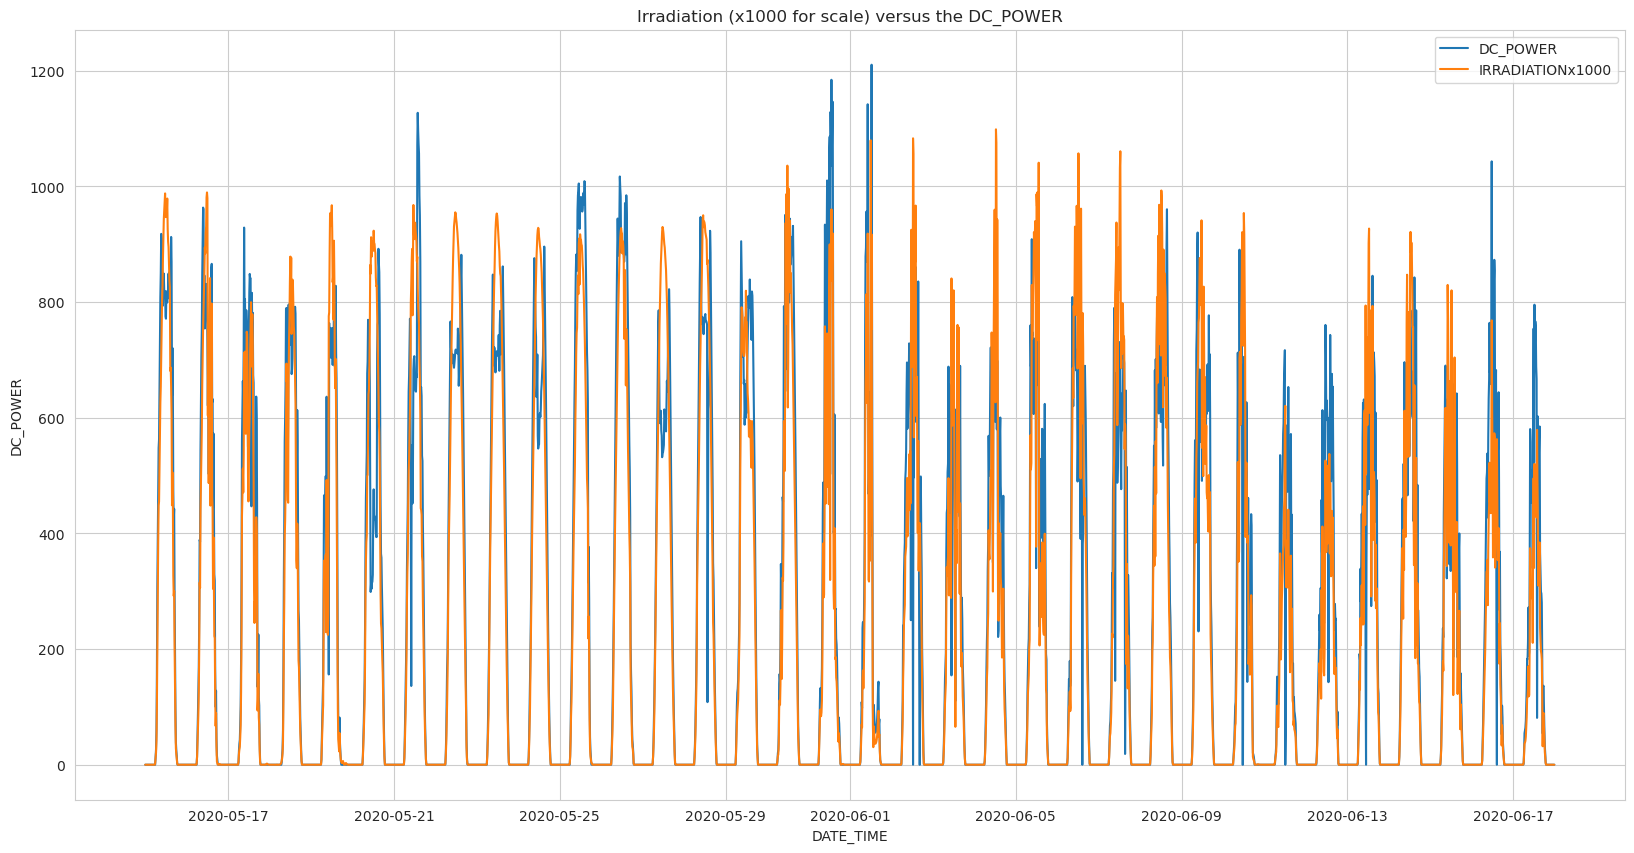

In [54]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df_group2, x=df_group2.index, y='DC_POWER', label='DC_POWER')
sns.lineplot(data=df_group2, x=df_group2.index, y='IRRADIATIONx1000', label='IRRADIATIONx1000')
plt.title('Irradiation (x1000 for scale) versus the DC_POWER')

# Next lets create a correlation plot
## some things to note from this -
### DC power is 100% correlated to IRRADIATION - that's what solar panels do !
### AMBIENT_TEMPERATURE is strongly correlated to the DC power and moderately correlated to the DAILY_YIELD (presuming is it hotter when it is sunnier!)

<AxesSubplot: >

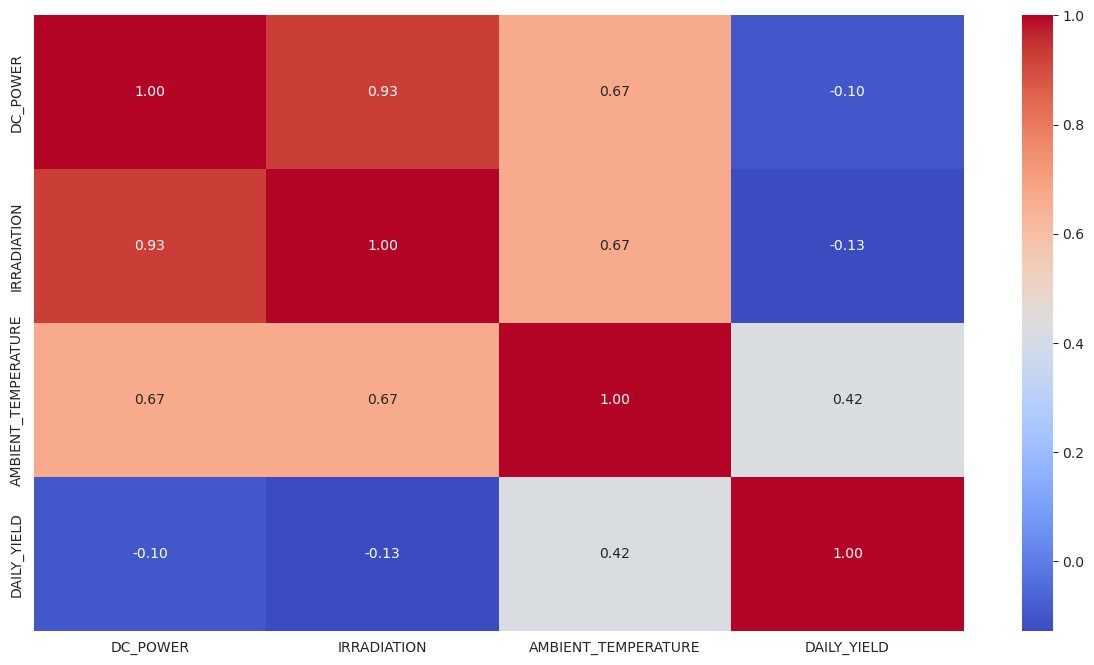

In [30]:
# get correlations for all columns except the 'IRRADIATIONx1000' that was used tfor graphing only
corr = df_group2.loc[:, df_group2.columns !='IRRADIATIONx1000'].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

# Based on this above graph we can see that there is an obvious relationship between IRRADIATION and the DC_POWER - next thing is to try to quantify it. Though it is 0.93 for Plant_2 - it was 1 for Plant_1

# I decided to compare the total daily values by resampling the data to D for daily and then mulitplying the IRRADIANCE by 1000 to get the same scale.
# The patterns matches almost exactly - see the graph below - remember the values aren't of the same scale so it is the pattern we are looking at.

In [31]:
# resample the data to daily values and X1000 to get IRRADIATION to the same scale
df_resample2 = df_group2.resample('D').sum()
df_resample2['IRRADIATIONx1000'] = df_resample2['IRRADIATION']*1000
df_resample2

,DC_POWER,IRRADIATION,AMBIENT_TEMPERATURE,DAILY_YIELD,IRRADIATIONx1000
DATE_TIME,,,,,
2020-05-15,30300.346861,28.559055,2903.769278,363518.728571,28559.055170
2020-05-16,25765.447273,23.676573,2829.946762,328848.086580,23676.572850
2020-05-17,25283.496282,21.233595,2858.890508,305102.967566,21233.595056
2020-05-18,24126.076234,21.495780,2624.322622,284503.949351,21495.780314
2020-05-19,20158.902137,20.345321,2517.562616,250553.021528,20345.320608
2020-05-20,22231.301995,26.786871,2710.369533,296510.438119,26786.870655
2020-05-21,27450.681111,27.191185,2789.324214,315238.508995,27191.184876
2020-05-22,27706.184868,28.535843,2846.262312,327625.782438,28535.843056
2020-05-23,27879.071931,28.159981,2942.361501,349283.828571,28159.980568


Text(0.5, 1.0, 'Daily values for total IRRADIANCE(x1000) and total DAILY_YIELD')

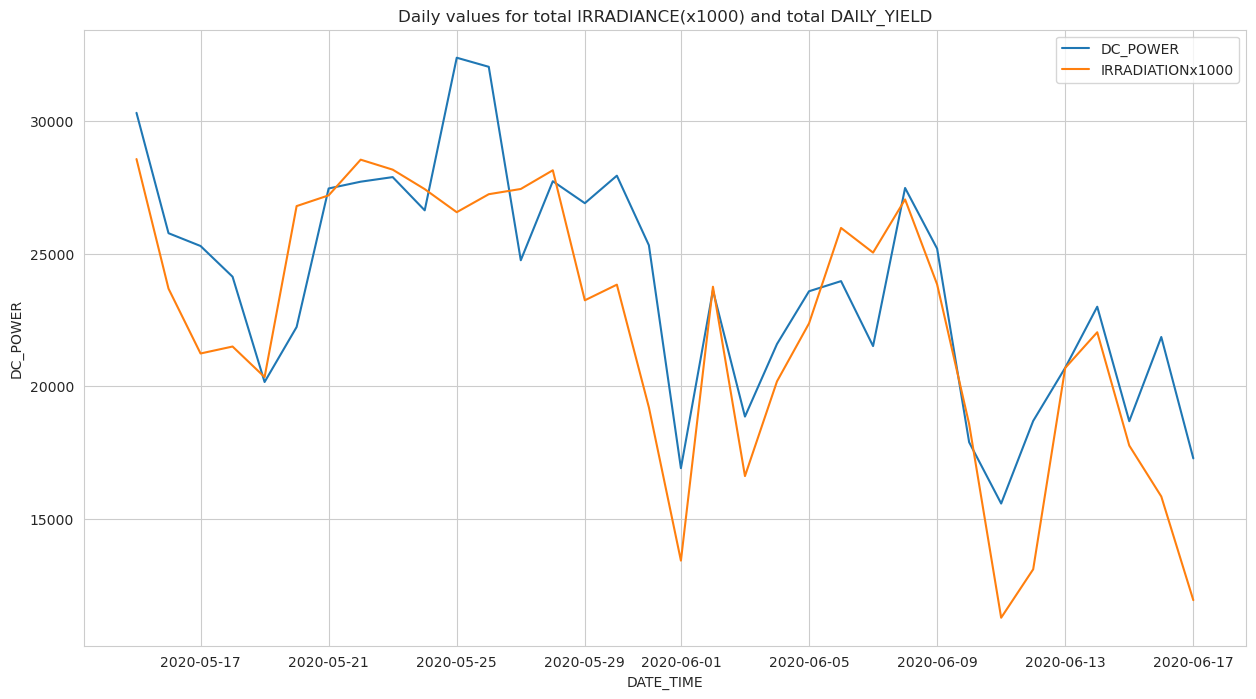

In [33]:
# Plot the newly calculated daily values

sns.lineplot(data=df_resample2, x=df_resample2.index, y='DC_POWER', label='DC_POWER')
sns.lineplot(data=df_resample2, x=df_resample2.index, y='IRRADIATIONx1000', label='IRRADIATIONx1000')
plt.title("Daily values for total IRRADIANCE(x1000) and total DAILY_YIELD")


# Because the DC power output is highly correlated to the IRRADIATION the ability of any model to forecast it would be very good - from a simply linear regression to an XGBoost model - I will do both here and compare the results.
## Split the data into a trainining set and a test set (70 training/30 testing) and then use the algorithms to make a prediction of the DC_POWER using the IRRADIATION values
## I will use the grouped data with the mean of all the sensors rather than a specific sensor.

In [35]:
# just use the IRRADIATION and AMBIENT_TEMPERATURE to predict the AC_POWER
X = df_group2.drop(['DC_POWER', 'IRRADIATIONx1000'],axis=1)
y = df_group2['DC_POWER']

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70,  shuffle=False, random_state=42) 

# Do cross verification to work out the best parameter combination

In [37]:
# A parameter grid for XGBoost
params = {
        'learning_rate': [0.001,  0.01,  0.1],
        'n_estimators': [100, 500, 1000],
        'max_depth': [3, 5, 7,9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'reg_alpha': [0.01, 0.05, 0.1],
        'reg_lambda': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        #'n_thread':[1,3,5]
        }

folds = 3
param_comb = 5

kf = KFold(n_splits=folds, shuffle = True, random_state = 42)

model = xgb.XGBRegressor() #learning_rate=0.01, n_estimators=1000,silent=True, eval_metric='mlogloss', nthread=1) # objective='binary:logistic',  

# Define RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=params,    n_iter=10, cv=kf, verbose=1,  scoring='neg_mean_squared_error', random_state=42)

# Here we go

random_search.fit(X_train, y_train)

print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

 All results:
{'mean_fit_time': array([0.06162794, 0.22381345, 0.03141427, 0.03691236, 0.13140035,
       0.03125437, 0.03177468, 0.03991938, 0.23830827, 0.03113063]), 'std_fit_time': array([0.02772855, 0.01993953, 0.00050519, 0.00131445, 0.0038502 ,
       0.00250243, 0.00116623, 0.00048304, 0.00147805, 0.00024942]), 'mean_score_time': array([0.00165041, 0.00285498, 0.00144196, 0.00173195, 0.00250181,
       0.00153852, 0.00148678, 0.00158493, 0.0028336 , 0.0014116 ]), 'std_score_time': array([1.59886319e-04, 5.71741683e-04, 1.92485169e-05, 5.44883684e-05,
       3.92813227e-04, 9.96310136e-05, 5.11839769e-05, 3.17358524e-05,
       1.50839404e-05, 5.91205435e-06]), 'param_subsample': masked_array(data=[0.6, 1.0, 0.8, 0.8, 0.8, 1.0, 0.6, 1.0, 0.6, 1.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_reg_lam

In [38]:
# Using the best params from above we can test the model
best_params = {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.05, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1.5, 'colsample_bytree': 1.0}
# define the model
xgb_model = xgb.XGBRegressor(**best_params)
# fit the model
xgb_model.fit(X_train, y_train)
# make a prediction
y_pred = xgb_model.predict(X_test)
# evaluate
print('Model score: ',xgb_model.score(X_test, y_test))
print('MAE:', mean_absolute_error(y_test, y_pred)) 
print('MSE:', mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

Model score:  0.9169776364258221
MAE: 39.05204181358616
MSE: 7809.387939931433
RMSE 88.37074142458822


# Store the results into a dataframe for plotting
## The plot shows just how accurate the prediction is 

In [39]:
df_results_xgb = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df_results_xgb

,y_test,y_pred
DATE_TIME,,
2020-05-25 04:45:00,0.0,0.184093
2020-05-25 05:00:00,0.0,0.184093
2020-05-25 05:15:00,0.0,0.184093
2020-05-25 05:30:00,0.0,0.184093
2020-05-25 05:45:00,0.0,0.184093
...,...,...
2020-06-17 22:45:00,0.0,0.244112
2020-06-17 23:00:00,0.0,0.244112
2020-06-17 23:15:00,0.0,0.244112


Text(0.5, 1.0, 'XGBoost prediction of DC_POWER (orange) and the Actual values (blue)')

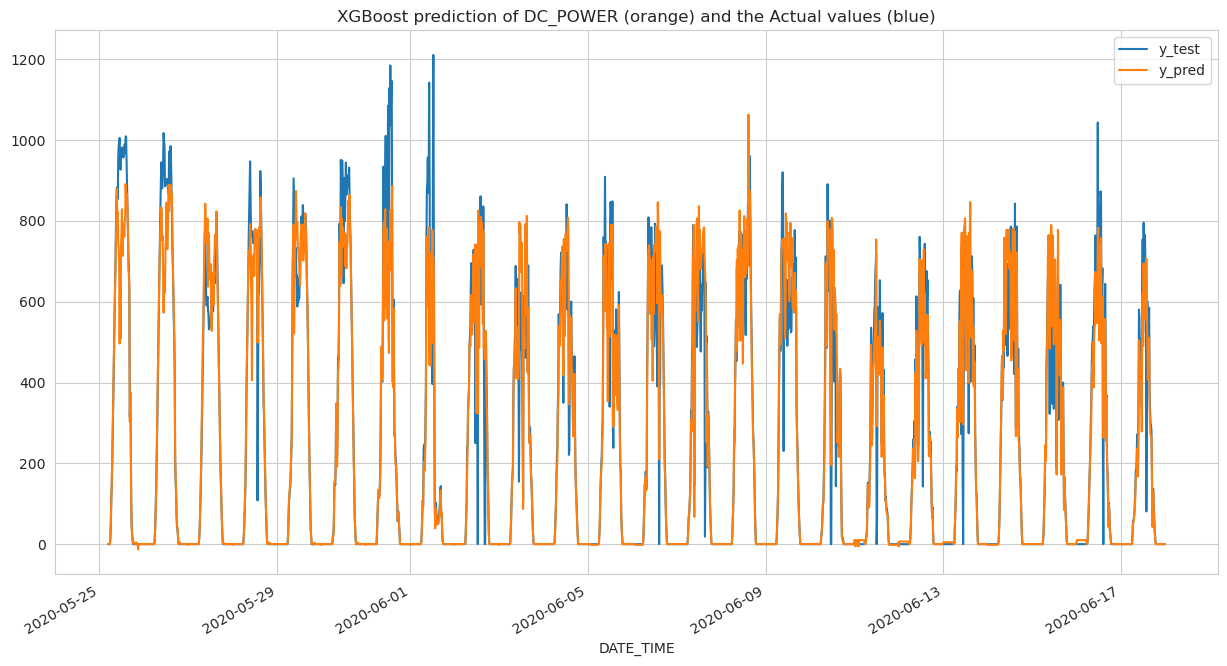

In [40]:
# Plot 
df_results_xgb.plot()
plt.title('XGBoost prediction of DC_POWER (orange) and the Actual values (blue)')

# Linear Regression Model

In [41]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Model score: ',xgb_model.score(X_test, y_test))
print('MAE:', mean_absolute_error(y_test, y_pred)) 
print('MSE:', mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

Model score:  0.9169776364258221
MAE: 80.22835981583677
MSE: 14978.068122232022
RMSE 122.38491787075735


In [159]:
df_results_lr = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df_results_lr

,y_test,y_pred
DATE_TIME,,
2020-05-25 15:00:00,10099.922078,10061.031993
2020-05-25 15:15:00,8880.358766,9049.985730
2020-05-25 15:30:00,7893.991071,6817.568101
2020-05-25 15:45:00,8508.495941,8436.034813
2020-05-25 16:00:00,7667.707792,7425.676659
...,...,...
2020-06-17 22:45:00,0.000000,-38.608079
2020-06-17 23:00:00,0.000000,-39.205733
2020-06-17 23:15:00,0.000000,-42.705755


Text(0.5, 1.0, 'Linear Regression prediction of DC_POWER (orange) and the Actual values (blue)')

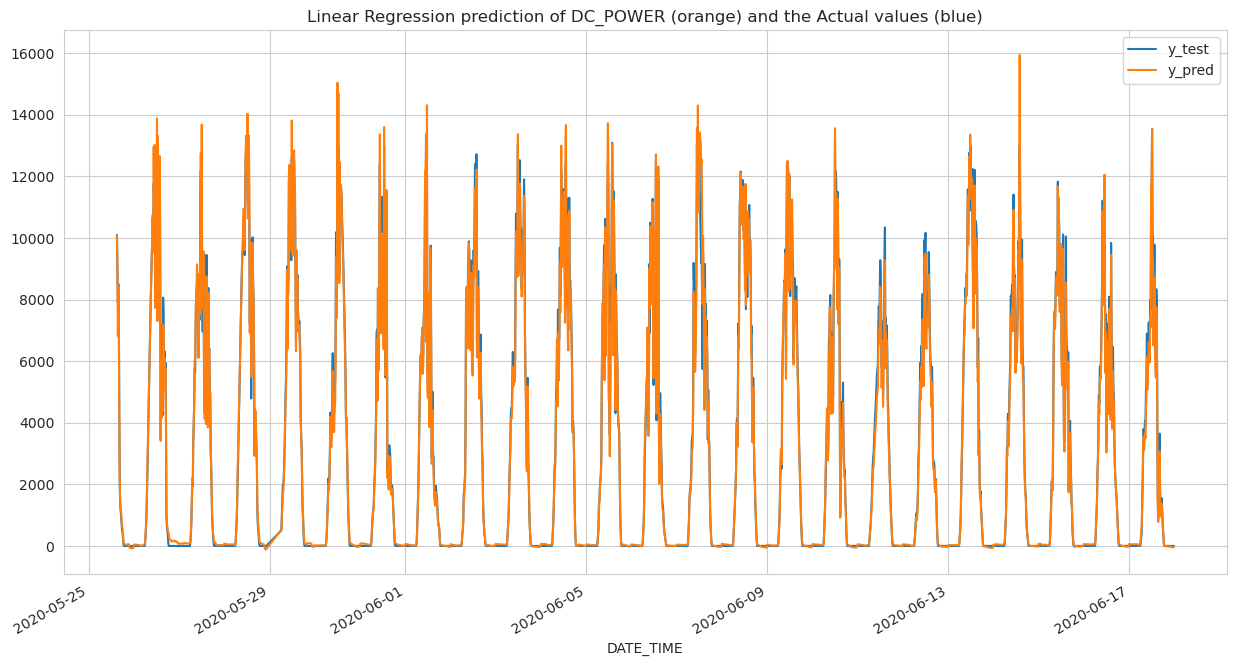

In [160]:
# Plot 
df_results_xgb.plot()
plt.title('Linear Regression prediction of DC_POWER (orange) and the Actual values (blue)')

# As expected the linear regression model was able to get the same score though a larger RMSE. 
# The data for Plant_2 is not as completas for Plant_1 hence there is a 
# This is due in fact to the strong correlation between the IRRADIATION and the DC_POWER and should be expected - in fact any other model should be able to get good results

# I will test this using the function defined below that gives output for Linear, decision tree, support vector, Lasso, random forest regression and extreme gradient boost regressors - though XGBoost is still the most accurate.



In [49]:
'''
Function to perform regressions, accuracy calculations and plots
'''    

def regression_calculations(X_train, y_train, X_test, y_test, regressor):
    #regr = regressor
    regr = regressor.fit(X_train,y_train)
    y_pred = regr.predict(X_test)
    # store the orignial and predicted value in a dataframe
    df_final = pd.DataFrame(data={'Predictions':y_pred, 'Actuals':y_test })  
    
    print('Accuragy for                       ',regressor, ' = {:.4f}'.format(regr.score(X_test, y_test)))    
    print('The mean absolute error (MAE) for  ',regressor, ' = {:.2f}'.format(mean_absolute_error( df_final['Actuals'],df_final['Predictions'])))
    print('The RMSE error (RMSE) for          ',regressor, ' = {:.2f}'.format(mean_squared_error( df_final['Actuals'],df_final['Predictions']), squared=False))
    
    print('\n\n')
    
    return y_pred

In [52]:
# define the different regressors
regressors = [DecisionTreeRegressor(), SVR(), linear_model.Lasso(), RandomForestRegressor(), GradientBoostingRegressor()] 

In [53]:
pred=0
for regressor in regressors:
    pred = regression_calculations(X_train, y_train, X_test, y_test, regressor)

Accuragy for                        DecisionTreeRegressor()  = 0.9005
The mean absolute error (MAE) for   DecisionTreeRegressor()  = 41.53
The RMSE error (RMSE) for           DecisionTreeRegressor()  = 9360.44



Accuragy for                        SVR()  = -0.3582
The mean absolute error (MAE) for   SVR()  = 241.32
The RMSE error (RMSE) for           SVR()  = 127759.04



Accuragy for                        Lasso()  = 0.8377
The mean absolute error (MAE) for   Lasso()  = 82.09
The RMSE error (RMSE) for           Lasso()  = 15269.74



Accuragy for                        RandomForestRegressor()  = 0.9190
The mean absolute error (MAE) for   RandomForestRegressor()  = 37.04
The RMSE error (RMSE) for           RandomForestRegressor()  = 7617.44



Accuragy for                        GradientBoostingRegressor()  = 0.9181
The mean absolute error (MAE) for   GradientBoostingRegressor()  = 37.54
The RMSE error (RMSE) for           GradientBoostingRegressor()  = 7704.76



